In [0]:
!wget -cq -O processed_celeba_small.zip https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip  
print("Downloaded Successfully")

Downloaded Successfully


In [0]:
!unzip -n processed_celeba_small.zip
print("Extracted Successfully")

Extracted Successfully


In [0]:
data_dir = 'processed_celeba_small/'
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
%matplotlib inline

In [0]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [0]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 4)
    return data_loader


In [0]:
batch_size = 128
img_size = 32
celeba_train_loader = get_dataloader(batch_size, img_size)

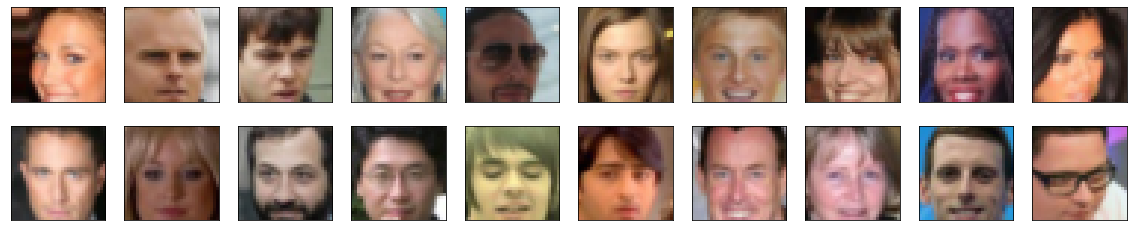

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() 

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [0]:
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
img = images[0]
scaled_img = scale(img)
print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.fc(out)        
        return out

tests.test_discriminator(Discriminator)

Tests Passed


In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) 
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = self.t_conv3(out)
        out = torch.tanh(out)
        return out
 
tests.test_generator(Generator)

Tests Passed


In [0]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1 or classname.find('Convo2d') != -1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

In [0]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)
    return D, G

In [0]:
d_conv_dim = 32
g_conv_dim = 32
z_size = 100
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [0]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)   
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)    
    if train_on_gpu:
        labels = labels.cuda()   
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
import torch.optim as optim
lr = 0.002
beta1=0.4
beta2=0.999
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [0]:
def train(D, G, n_epochs, print_every=300):
    samples = []
    losses = []
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)           
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            

            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
                
        G.eval() 
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() 

    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [0]:
n_epochs = 20
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.4258 | g_loss: 2.9895
Epoch [    1/   20] | d_loss: 1.3819 | g_loss: 3.3006
Epoch [    1/   20] | d_loss: 1.3120 | g_loss: 0.9933
Epoch [    2/   20] | d_loss: 0.9584 | g_loss: 2.0657
Epoch [    2/   20] | d_loss: 2.4936 | g_loss: 0.6182
Epoch [    2/   20] | d_loss: 1.0139 | g_loss: 1.9535
Epoch [    3/   20] | d_loss: 1.2601 | g_loss: 2.1032
Epoch [    3/   20] | d_loss: 1.0274 | g_loss: 1.5565
Epoch [    3/   20] | d_loss: 0.9556 | g_loss: 1.3888
Epoch [    4/   20] | d_loss: 1.0753 | g_loss: 1.7005
Epoch [    4/   20] | d_loss: 0.9473 | g_loss: 1.4204
Epoch [    4/   20] | d_loss: 1.0619 | g_loss: 1.5058
Epoch [    5/   20] | d_loss: 1.0511 | g_loss: 1.0570
Epoch [    5/   20] | d_loss: 1.0925 | g_loss: 3.1772
Epoch [    5/   20] | d_loss: 1.0508 | g_loss: 2.5102
Epoch [    6/   20] | d_loss: 1.4954 | g_loss: 3.2887
Epoch [    6/   20] | d_loss: 1.1057 | g_loss: 2.4185
Epoch [    6/   20] | d_loss: 0.8723 | g_loss: 2.3219
Epoch [    7/   20] | d_loss

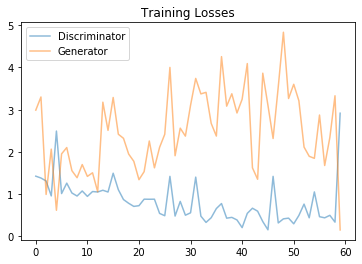

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

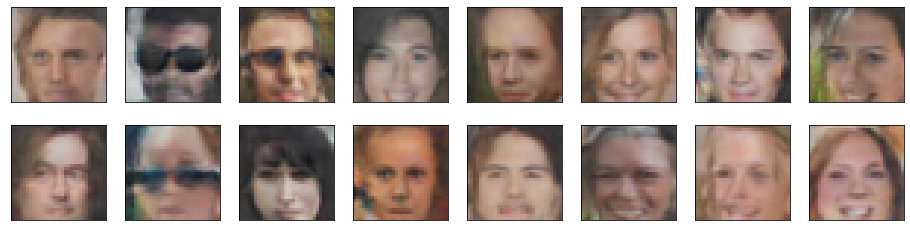

In [0]:
_ = view_samples(-1, samples)